<h1 style="color:blue;">Setting up Dependencies</h1>

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

In [2]:
import os

# Set spark environments
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/usr/bin/python3'

In [3]:
import re
import pandas as pd

<h1 style="color:blue;">Basic Regular Expressions</h1>

In [4]:
m = re.finditer(r'.*?(spark).*?', "I'm searching for a spark in PySpark", re.I)
for match in m:
    print(match, match.start(), match.end())

<_sre.SRE_Match object; span=(0, 25), match="I'm searching for a spark"> 0 25
<_sre.SRE_Match object; span=(25, 36), match=' in PySpark'> 25 36


<h1 style="color:blue;">Loading the dataset</h1>

In [5]:
acunetix = "data/netsparker.txt"

<h1 style="color:blue">Taking a look at the metadata of our dataframe</h1>

In [6]:
base_df = spark.read.text(acunetix)
base_df.printSchema()

root
 |-- value: string (nullable = true)



In [7]:
type(base_df)

pyspark.sql.dataframe.DataFrame

In [8]:
base_df_rdd = base_df.rdd
type(base_df_rdd)

pyspark.rdd.RDD

<h1 style="color:blue;">Viewing sample data in our dataframe 
Looks like it needs to be wrangled and parsed!</h1>


In [9]:
base_df.show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                             |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|"192.168.4.164 - - [22/Dec/2016:15:19:05 +0300] "GET /DVWA/ HTTP/1.1" 200 2020 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""                |
|"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/ HTTP/1.1" 200 263 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, 

<h4 style="color:blue;">Getting data from an RDD is slightly different. You can see how the data representation is different in the following RDD<h4>

In [10]:
base_df_rdd.take(10)

[Row(value='"192.168.4.164 - - [22/Dec/2016:15:19:05 +0300] "GET /DVWA/ HTTP/1.1" 200 2020 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""'),
 Row(value='"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/ HTTP/1.1" 200 263 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""'),
 Row(value='"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/.git/config HTTP/1.1" 404 139 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""'),
 Row(value='"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/.git/config HTTP/1.1" 404 139 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""'),
 Row(value='"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/.svn/all-wcprops HTTP/1.1" 404 139 "-" "Mozilla/5.0 (Windows NT 6.

<h1 style="color:blue;">Data Wrangling</h1>


<h2 style="color:blue;">Data Parsing and Extraction with Regular Expressions</h2>

In [11]:
print((base_df.count(), len(base_df.columns)))

(7314, 1)


<h3 style="color:blue;">Let's extract and take a look at some sample log messages</h3>

In [12]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['"192.168.4.164 - - [22/Dec/2016:15:19:05 +0300] "GET /DVWA/ HTTP/1.1" 200 2020 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""',
 '"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/ HTTP/1.1" 200 263 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""',
 '"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/.git/config HTTP/1.1" 404 139 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""',
 '"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/.git/config HTTP/1.1" 404 139 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""',
 '"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/.svn/all-wcprops HTTP/1.1" 404 139 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrom


<h2 style="color:blue;">Extracting host names</h2>



In [13]:
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
hosts = [re.search(host_pattern, item).group(1)
           if re.search(host_pattern, item)
           else 'no match'
           for item in sample_logs]
hosts

['"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164',
 '"192.168.4.164']


<h2 style="color:blue;">Extracting timestamps</h2>


In [14]:
from pyspark.sql.functions import date_format

In [15]:
# \[(?P<time>.+)\]
ts_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} .+\d{4})]'
timestamps = [re.search(ts_pattern, item).group(1) for item in sample_logs]
timestamps

['22/Dec/2016:15:19:05 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300']


<h2 style="color:blue;">Extracting HTTP Request Method, URIs and Protocol</h2>



In [16]:
method_uri_protocol_pattern = r'\"(\S+)\s(\S+)\s*(\S*)\"'
method_uri_protocol = [re.search(method_uri_protocol_pattern, item).groups()
               if re.search(method_uri_protocol_pattern, item)
               else 'no match'
              for item in sample_logs]
method_uri_protocol

[('GET', '/DVWA/', 'HTTP/1.1'),
 ('HEAD', '/DVWA/', 'HTTP/1.1'),
 ('HEAD', '/DVWA/.git/config', 'HTTP/1.1'),
 ('HEAD', '/DVWA/.git/config', 'HTTP/1.1'),
 ('HEAD', '/DVWA/.svn/all-wcprops', 'HTTP/1.1'),
 ('HEAD', '/DVWA/.svn/all-wcprops', 'HTTP/1.1'),
 ('HEAD', '/DVWA/.svn/wc.db', 'HTTP/1.1'),
 ('HEAD', '/DVWA/.svn/wc.db', 'HTTP/1.1'),
 ('HEAD', '/DVWA/~.aspx', 'HTTP/1.1'),
 ('HEAD', '/DVWA/~.aspx', 'HTTP/1.1'),
 ('HEAD', '/DVWA/cgi-bin/', 'HTTP/1.1'),
 ('HEAD', '/DVWA/cgi-bin/', 'HTTP/1.1'),
 ('HEAD', '/DVWA/cgi-sys/', 'HTTP/1.1'),
 ('HEAD', '/DVWA/cgi-sys/', 'HTTP/1.1'),
 ('HEAD', '/DVWA/config.inc', 'HTTP/1.1')]


<h2 style="color:blue;">Extracting HTTP Status Codes</h2>



In [17]:
status_pattern = r'\s(\d{3})\s'
status = [re.search(status_pattern, item).group(1) for item in sample_logs]
print(status)

['200', '200', '404', '404', '404', '404', '404', '404', '404', '404', '404', '404', '404', '404', '404']


<h2 style="color:blue;">Extracting HTTP Response Content Size</h2>



In [18]:
content_size_pattern = r'\s(\d+) \"'
content_size = [re.search(content_size_pattern, item).group(1) for item in sample_logs]
print(content_size)

['2020', '263', '139', '139', '139', '139', '139', '139', '139', '139', '139', '139', '139', '139', '139']



<h2 style="color:blue;">Putting it all together</h2>



In [19]:
from pyspark.sql.functions import regexp_extract

logs_df = base_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                         regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                         regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                         regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                         regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                         regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                         regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
logs_df.show(10, truncate=True)
print((logs_df.count(), len(logs_df.columns)))

+--------------+--------------------+------+--------------------+--------+------+------------+
|          host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------+--------------------+------+--------------------+--------+------+------------+
|"192.168.4.164|22/Dec/2016:15:19...|   GET|              /DVWA/|HTTP/1.1|   200|        2020|
|"192.168.4.164|22/Dec/2016:15:19...|  HEAD|              /DVWA/|HTTP/1.1|   200|         263|
|"192.168.4.164|22/Dec/2016:15:19...|  HEAD|   /DVWA/.git/config|HTTP/1.1|   404|         139|
|"192.168.4.164|22/Dec/2016:15:19...|  HEAD|   /DVWA/.git/config|HTTP/1.1|   404|         139|
|"192.168.4.164|22/Dec/2016:15:19...|  HEAD|/DVWA/.svn/all-wc...|HTTP/1.1|   404|         139|
|"192.168.4.164|22/Dec/2016:15:19...|  HEAD|/DVWA/.svn/all-wc...|HTTP/1.1|   404|         139|
|"192.168.4.164|22/Dec/2016:15:19...|  HEAD|    /DVWA/.svn/wc.db|HTTP/1.1|   404|         139|
|"192.168.4.164|22/Dec/2016:15:19...|  HEAD|    /D


<h2 style="color:blue;">Finding Missing Values</h2>



In [20]:
(base_df
    .filter(base_df['value']
                .isNull())
    .count())


0

<h2 style="color:blue;">If our data parsing and extraction worked properly, we should not have any rows with potential null values. Let's try and put that to test!</h2>

In [21]:
bad_rows_df = logs_df.filter(logs_df['host'].isNull()| 
                             logs_df['timestamp'].isNull() | 
                             logs_df['method'].isNull() |
                             logs_df['endpoint'].isNull() |
                             logs_df['status'].isNull() |
                             logs_df['content_size'].isNull()|
                             logs_df['protocol'].isNull())
bad_rows_df.count()

0

<h2 style="color:blue;">Finding Null Counts</h2>

In [22]:
logs_df.columns

['host',
 'timestamp',
 'method',
 'endpoint',
 'protocol',
 'status',
 'content_size']

In [23]:
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in logs_df.columns]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+




<h2 style="color:blue;">Handling nulls in HTTP status</h2>


In [24]:
null_status_df = base_df.filter(~base_df['value'].rlike(r'\s(\d{3})\s'))
null_status_df.count()

0

In [25]:
null_status_df.show(truncate=False)

+-----+
|value|
+-----+
+-----+



In [26]:
bad_status_df = null_status_df.select(regexp_extract('value', host_pattern, 1).alias('host'),
                                      regexp_extract('value', ts_pattern, 1).alias('timestamp'),
                                      regexp_extract('value', method_uri_protocol_pattern, 1).alias('method'),
                                      regexp_extract('value', method_uri_protocol_pattern, 2).alias('endpoint'),
                                      regexp_extract('value', method_uri_protocol_pattern, 3).alias('protocol'),
                                      regexp_extract('value', status_pattern, 1).cast('integer').alias('status'),
                                      regexp_extract('value', content_size_pattern, 1).cast('integer').alias('content_size'))
bad_status_df.show(truncate=False)

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
+----+---------+------+--------+--------+------+------------+



In [27]:
logs_df.count()

7314

In [28]:
logs_df = logs_df[logs_df['status'].isNotNull()] 
logs_df.count()

7314

In [29]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+




<h2 style="color:blue;">Handling nulls in HTTP content size</h2>


In [30]:
null_content_size_df = base_df.filter(~base_df['value'].rlike(r'\s\d+$'))
null_content_size_df.count()

7314

In [31]:
null_content_size_df.take(10)

[Row(value='"192.168.4.164 - - [22/Dec/2016:15:19:05 +0300] "GET /DVWA/ HTTP/1.1" 200 2020 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""'),
 Row(value='"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/ HTTP/1.1" 200 263 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""'),
 Row(value='"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/.git/config HTTP/1.1" 404 139 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""'),
 Row(value='"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/.git/config HTTP/1.1" 404 139 "-" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""'),
 Row(value='"192.168.4.164 - - [22/Dec/2016:15:19:06 +0300] "HEAD /DVWA/.svn/all-wcprops HTTP/1.1" 404 139 "-" "Mozilla/5.0 (Windows NT 6.

In [32]:
logs_df = logs_df.na.fill({'content_size': 0})

In [33]:
exprs = [count_null(col_name) for col_name in logs_df.columns]
logs_df.agg(*exprs).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+




<h2 style="color:blue;">Handling Temporal Fields (Timestamp)</h2>


In [34]:
from pyspark.sql.functions import udf

month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(text):
    """ Convert Common Log time format into a Python datetime object
    Args:
        text (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring the time zones here, might need to be handled depending on the problem you are solving
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(text[7:11]),
      month_map[text[3:6]],
      int(text[0:2]),
      int(text[12:14]),
      int(text[15:17]),
      int(text[18:20])
    )

In [35]:
sample_ts = [item['timestamp'] for item in logs_df.select('timestamp').take(5)]
sample_ts

['22/Dec/2016:15:19:05 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300',
 '22/Dec/2016:15:19:06 +0300']

In [36]:
# [parse_clf_time(item) for item in sample_ts]

In [37]:
udf_parse_time = udf(parse_clf_time)

logs_df = logs_df.select('*', udf_parse_time(logs_df['timestamp']).cast('timestamp').alias('time')).drop('timestamp')
logs_df.show(10, truncate=True)

+--------------+------+--------------------+--------+------+------------+-------------------+
|          host|method|            endpoint|protocol|status|content_size|               time|
+--------------+------+--------------------+--------+------+------------+-------------------+
|"192.168.4.164|   GET|              /DVWA/|HTTP/1.1|   200|        2020|2016-12-22 15:19:05|
|"192.168.4.164|  HEAD|              /DVWA/|HTTP/1.1|   200|         263|2016-12-22 15:19:06|
|"192.168.4.164|  HEAD|   /DVWA/.git/config|HTTP/1.1|   404|         139|2016-12-22 15:19:06|
|"192.168.4.164|  HEAD|   /DVWA/.git/config|HTTP/1.1|   404|         139|2016-12-22 15:19:06|
|"192.168.4.164|  HEAD|/DVWA/.svn/all-wc...|HTTP/1.1|   404|         139|2016-12-22 15:19:06|
|"192.168.4.164|  HEAD|/DVWA/.svn/all-wc...|HTTP/1.1|   404|         139|2016-12-22 15:19:06|
|"192.168.4.164|  HEAD|    /DVWA/.svn/wc.db|HTTP/1.1|   404|         139|2016-12-22 15:19:06|
|"192.168.4.164|  HEAD|    /DVWA/.svn/wc.db|HTTP/1.1|   404|

In [38]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [39]:
logs_df.limit(5).toPandas()

,host,method,endpoint,protocol,status,content_size,time
0,"""192.168.4.164",GET,/DVWA/,HTTP/1.1,200,2020,2016-12-22 15:19:05
1,"""192.168.4.164",HEAD,/DVWA/,HTTP/1.1,200,263,2016-12-22 15:19:06
2,"""192.168.4.164",HEAD,/DVWA/.git/config,HTTP/1.1,404,139,2016-12-22 15:19:06
3,"""192.168.4.164",HEAD,/DVWA/.git/config,HTTP/1.1,404,139,2016-12-22 15:19:06
4,"""192.168.4.164",HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,2016-12-22 15:19:06


In [40]:
logs_df.cache()

DataFrame[host: string, method: string, endpoint: string, protocol: string, status: int, content_size: int, time: timestamp]

<h2 style="color:blue;">Data Analysis on our Web Logs</h2>


In [41]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,7314
1,mean,806.7842493847415
2,stddev,1356.009850161569
3,min,126
4,max,19669


In [42]:
from pyspark.sql import functions as F

(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,126,19669,806.784249,1356.00985,7314



<h2 style="color:blue;">HTTP Status Code Analysis</h2>


In [43]:
status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())

In [44]:
print('Total distinct HTTP Status Codes:', status_freq_df.count())

Total distinct HTTP Status Codes: 5


In [45]:
status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
status_freq_pd_df

,status,count
0,200,3784
2,404,2602
1,302,910
3,405,12
4,500,6


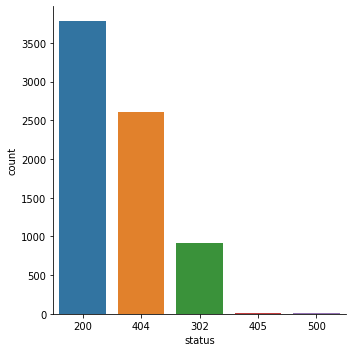

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='status', y='count', data=status_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

In [47]:
log_freq_df = status_freq_df.withColumn('log(count)', F.log(status_freq_df['count']))
log_freq_df.show()

+------+-----+------------------+
|status|count|        log(count)|
+------+-----+------------------+
|   200| 3784| 8.238536930171769|
|   302|  910| 6.813444599510896|
|   404| 2602|  7.86403565907245|
|   405|   12|2.4849066497880004|
|   500|    6| 1.791759469228055|
+------+-----+------------------+



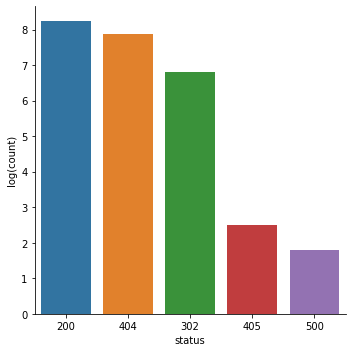

In [48]:
log_freq_pd_df = (log_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='status', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])

<h2 style="color:blue;">HTTP methods Analysis</h2>

In [49]:
method_freq_df = (logs_df
                     .groupBy('method')
                     .count()
                     .sort('method')
                     .cache())

In [50]:
print('Total distinct HTTP Status Codes:', method_freq_df.count())

Total distinct HTTP Status Codes: 6


In [51]:
method_freq_pd_df = (method_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
method_freq_pd_df

,method,count
0,GET,4004
1,HEAD,2038
4,POST,1203
3,OPTIONS,34
5,PROPFIND,34
2,NETSPARKER,1


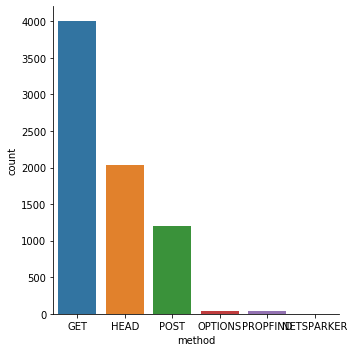

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

sns.catplot(x='method', y='count', data=method_freq_pd_df, 
            kind='bar', order=method_freq_pd_df['method'])

In [53]:
mlog_freq_df = method_freq_df.withColumn('log(count)', F.log(method_freq_df['count']))
mlog_freq_df.show()

+----------+-----+------------------+
|    method|count|        log(count)|
+----------+-----+------------------+
|       GET| 4004| 8.295049140435111|
|      HEAD| 2038|  7.61972421378267|
|NETSPARKER|    1|               0.0|
|   OPTIONS|   34|3.5263605246161616|
|      POST| 1203|7.0925737159746784|
|  PROPFIND|   34|3.5263605246161616|
+----------+-----+------------------+



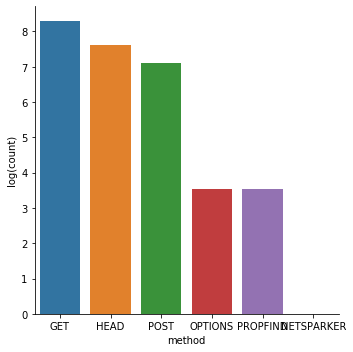

In [54]:
mlog_freq_pd_df = (mlog_freq_df
                    .toPandas()
                    .sort_values(by=['log(count)'],
                                 ascending=False))
sns.catplot(x='method', y='log(count)', data=mlog_freq_pd_df, 
            kind='bar', order=method_freq_pd_df['method'])


<h2 style="color:blue;">Analyzing Frequent Hosts</h2>




In [55]:
host_sum_df =(logs_df
               .groupBy('host')
               .count()
               .sort('count', ascending=False).limit(10))

host_sum_df.show(truncate=False)

+--------------+-----+
|host          |count|
+--------------+-----+
|"192.168.4.164|7314 |
+--------------+-----+



In [56]:
host_sum_pd_df = host_sum_df.toPandas()
host_sum_pd_df.iloc[0]['host']

'"192.168.4.164'


<h2 style="color:blue;">Display the Top 20 Frequent EndPoints</h2>


In [57]:
paths_df = (logs_df
            .groupBy('endpoint')
            .count()
            .sort('count', ascending=False).limit(20))

In [58]:
paths_pd_df = paths_df.toPandas()
paths_pd_df

,endpoint,count
0,/DVWA/login.php,1437
1,/DVWA/setup.php,311
2,/DVWA/vulnerabilities/exec/,298
3,/DVWA/vulnerabilities/xss_s/,19
4,/DVWA/vulnerabilities/captcha/,17
5,/DVWA/vulnerabilities/upload/,17
6,/DVWA/,17
7,/DVWA/vulnerabilities/sqli/,15
8,/DVWA/vulnerabilities/sqli_blind/,15
9,/DVWA/vulnerabilities/xss_r/,15



<h2 style="color:blue;">Top Ten Error Endpoints</h2>


In [59]:
not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )

In [60]:
error_endpoints_freq_df.show(truncate=False)

+------------------------------------------------------------------------+-----+
|endpoint                                                                |count|
+------------------------------------------------------------------------+-----+
|/DVWA/login.php                                                         |727  |
|/DVWA/setup.php                                                         |151  |
|/DVWA/include.php                                                       |9    |
|/DVWA/vulnerabilities/brute/include.php                                 |9    |
|/DVWA/vulnerabilities/exec/include.php                                  |9    |
|/DVWA/security.php?test=%22%3E%3Cscript%3Eeval(window.name)%3C/script%3E|3    |
|/DVWA/security.php                                                      |3    |
|/DVWA/adminadmin/                                                       |2    |
|/DVWA/webservice/                                                       |2    |
|/DVWA/site.conf            


<h2 style="color:blue;"> Total number of Unique Hosts</h2>




In [61]:
unique_host_count = (logs_df
                     .select('host')
                     .distinct()
                     .count())
unique_host_count

1

<h2 style="color:blue;">Number of Unique Daily Hosts</h2>


In [62]:
host_day_df = logs_df.select(logs_df.host, 
                             F.dayofmonth('time').alias('day'))
host_day_df.show(5, truncate=False)

+--------------+---+
|host          |day|
+--------------+---+
|"192.168.4.164|22 |
|"192.168.4.164|22 |
|"192.168.4.164|22 |
|"192.168.4.164|22 |
|"192.168.4.164|22 |
+--------------+---+
only showing top 5 rows



In [63]:
host_day_distinct_df = (host_day_df
                          .dropDuplicates())
host_day_distinct_df.show(5, truncate=False)

+--------------+---+
|host          |day|
+--------------+---+
|"192.168.4.164|22 |
+--------------+---+



In [64]:
def_mr = pd.get_option('max_rows')
pd.set_option('max_rows', 10)

daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))

daily_hosts_df = daily_hosts_df.toPandas()
daily_hosts_df

,day,count
0,22,1


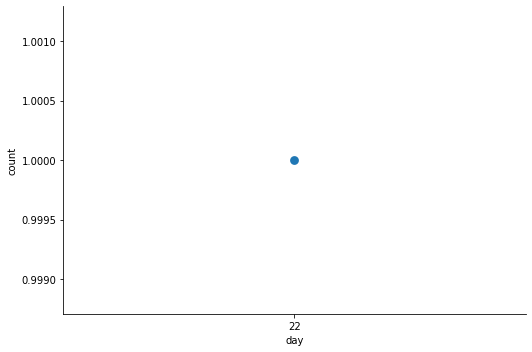

In [65]:
c = sns.catplot(x='day', y='count', 
                data=daily_hosts_df, 
                kind='point', height=5, 
                aspect=1.5)


<h2 style="color:blue;">Average Number of Daily Requests per Host</h4>


In [66]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col("day"), 
                                      col("count").alias("total_hosts")))

total_daily_reqests_df = (logs_df
                              .select(F.dayofmonth("time")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .select(col("day"), 
                                      col("count").alias("total_reqs")))

avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,22,7314,1,7314.0


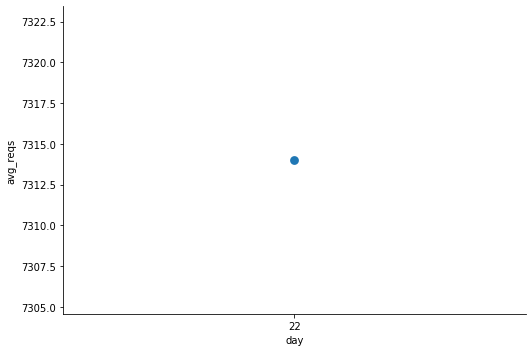

In [67]:
c = sns.catplot(x='day', y='avg_reqs', 
                data=avg_daily_reqests_per_host_df, 
                kind='point', height=5, aspect=1.5)


<h2 style="color:blue;">Counting 404 Response Codes</h2>



In [68]:
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 2602


<h2 style="color:blue;">Listing the Top Twenty 404 Response Code Endpoints</h2>

In [69]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+---------------------------------------+-----+
|endpoint                               |count|
+---------------------------------------+-----+
|/DVWA/include.php                      |9    |
|/DVWA/vulnerabilities/brute/include.php|9    |
|/DVWA/vulnerabilities/exec/include.php |9    |
|/DVWA/r57eng.php                       |2    |
|/DVWA/myservices/                      |2    |
|/DVWA/wsdl/                            |2    |
|/DVWA/session.inc                      |2    |
|/DVWA/urls.conf                        |2    |
|/DVWA/adminadmin/                      |2    |
|/DVWA/WS_FTP.log                       |2    |
|/DVWA/sftp-config.json                 |2    |
|/DVWA/controlpanel/                    |2    |
|/DVWA/fpadmin/                         |2    |
|/DVWA/manager/                         |2    |
|/DVWA/DAws.php                         |2    |
|/DVWA/.svn/all-wcprops                 |2    |
|/DVWA/axis/                            |2    |
|/DVWA/c99shell.php                     

<h2 style="color:blue;">Listing the Top Twenty 404 Response Code Hosts</h2>

In [70]:
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+--------------+-----+
|host          |count|
+--------------+-----+
|"192.168.4.164|2602 |
+--------------+-----+



<h2 style="color:blue;">Visualizing 404 Errors per Day</h2>

In [71]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,22,2602


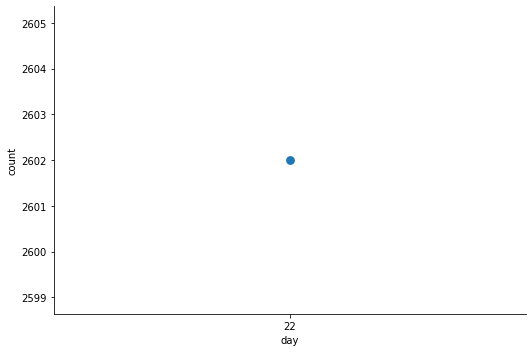

In [72]:
c = sns.catplot(x='day', y='count', 
                data=errors_by_date_sorted_pd_df, 
                kind='point', height=5, aspect=1.5)

<h2 style="color:blue;">Top Three Days for 404 Errors</h2>

In [73]:
(errors_by_date_sorted_df
    .sort("count", ascending=False)
    .show(3))

+---+-----+
|day|count|
+---+-----+
| 22| 2602|
+---+-----+



<h2 style="color:blue;">Visualizing Hourly 404 Errors</h2>

In [74]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(F.hour('time')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

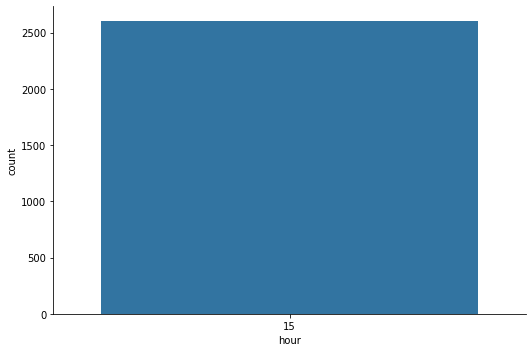

In [75]:
c = sns.catplot(x='hour', y='count', 
                data=hourly_avg_errors_sorted_pd_df, 
                kind='bar', height=5, aspect=1.5)